In [5]:
import numpy as np
import pandas as pd

# Define the board dimensions
BOARD_SIZE = 3

# Define player symbols (numerical representation)
PLAYER_X = 1
PLAYER_O = -1
EMPTY = 0

# Function to check for a winner
def check_winner(board):
    # Check rows
    for row in board:
        if abs(sum(row)) == BOARD_SIZE:
            return sum(row) // BOARD_SIZE
    # Check columns
    for col in board.T:
        if abs(sum(col)) == BOARD_SIZE:
            return sum(col) // BOARD_SIZE
    # Check diagonals
    if abs(np.trace(board)) == BOARD_SIZE:
        return np.trace(board) // BOARD_SIZE
    if abs(np.trace(np.fliplr(board))) == BOARD_SIZE:
        return np.trace(np.fliplr(board)) // BOARD_SIZE
    # No winner
    return 0

# Function to get available moves
def get_available_moves(board):
    moves = []
    for i in range(BOARD_SIZE):
        for j in range(BOARD_SIZE):
            if board[i, j] == EMPTY:
                moves.append((i, j))
    return moves

# Minimax function
def minimax(board, depth, is_maximizing_player):
    winner = check_winner(board)

    # Base cases
    if winner != 0:
        return winner * (10 - depth)  # Reward/penalty based on depth
    if not get_available_moves(board):
        return 0  # Draw

    if is_maximizing_player:
        max_eval = -np.inf
        for move in get_available_moves(board):
            new_board = board.copy()
            new_board[move] = PLAYER_X
            eval = minimax(new_board, depth + 1, False)
            max_eval = max(max_eval, eval)
        return max_eval
    else:
        min_eval = np.inf
        for move in get_available_moves(board):
            new_board = board.copy()
            new_board[move] = PLAYER_O
            eval = minimax(new_board, depth + 1, True)
            min_eval = min(min_eval, eval)
        return min_eval

# Function to find the best move
def find_best_move(board, player):
    best_eval = -np.inf if player == PLAYER_X else np.inf
    best_move = None

    for move in get_available_moves(board):
        new_board = board.copy()
        new_board[move] = player
        eval = minimax(new_board, 0, player == PLAYER_O)  # Switch to the other player for evaluation

        if player == PLAYER_X:
            if eval > best_eval:
                best_eval = eval
                best_move = move
        else: # player == PLAYER_O
            if eval < best_eval:
                best_eval = eval
                best_move = move
    return best_move

# Function to generate all possible board states recursively
def generate_board_states(board, current_player, dataset):
    winner = check_winner(board)
    if winner != 0 or not get_available_moves(board):
        return

    # Determine the best move for the current player
    best_move = find_best_move(board.copy(), current_player)

    # Create a flattened representation of the board and the best move
    flat_board = board.flatten().tolist()
    # Represent the best move as a single numerical index (row * BOARD_SIZE + col)
    best_move_index = best_move[0] * BOARD_SIZE + best_move[1]

    # Add the board state, current player, and best move to the dataset
    dataset.append(flat_board + [current_player, best_move_index])

    # Recursively generate states for the next move
    for move in get_available_moves(board):
        new_board = board.copy()
        new_board[move] = current_player
        next_player = PLAYER_O if current_player == PLAYER_X else PLAYER_X
        generate_board_states(new_board, next_player, dataset)

# Main logic to generate the dataset
dataset = []
initial_board = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=int)

# Generate states starting with Player X
generate_board_states(initial_board.copy(), PLAYER_X, dataset)

# Generate states starting with Player O (this will generate duplicates of board states but for the other player's turn)
generate_board_states(initial_board.copy(), PLAYER_O, dataset)


# Convert the dataset to a pandas DataFrame
column_names = [f'cell_{i}' for i in range(BOARD_SIZE * BOARD_SIZE)] + ['current_player', 'best_move_index']
df = pd.DataFrame(dataset, columns=column_names)

# Remove duplicate rows (same board state and current player)
df.drop_duplicates(inplace=True)

# Export to CSV
df.to_csv('tic_tac_toe_dataset.csv', index=False)

print("Dataset generated and saved to tic_tac_toe_dataset.csv")
print(f"Number of unique board states and player turns: {len(df)}")


Dataset generated and saved to tic_tac_toe_dataset.csv
Number of unique board states and player turns: 9040


In [6]:
df.head()

,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,current_player,best_move_index
0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,-1,4
2,1,-1,0,0,0,0,0,0,0,1,3
3,1,-1,1,0,0,0,0,0,0,-1,4
4,1,-1,1,-1,0,0,0,0,0,1,4


In [8]:
# prompt: display the count or number of rows of each unique current player

df['current_player'].value_counts()

,count
current_player,
1,4520
-1,4520


In [9]:

# Select rows where all cell columns are 0
# Assuming the cell columns are named 'cell_0' through 'cell_8'
cell_columns = [f'cell_{i}' for i in range(BOARD_SIZE * BOARD_SIZE)]
zero_rows = df[(df[cell_columns] == 0).all(axis=1)]

# Display the rows
print("Rows where all cell values are 0:")
zero_rows

Rows where all cell values are 0:


,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,current_player,best_move_index
0,0,0,0,0,0,0,0,0,0,1,0
294778,0,0,0,0,0,0,0,0,0,-1,0


In [12]:
# Count the number of empty cells (value 0) in each row's cell columns
df['empty_cell_count'] = (df[cell_columns] == 0).sum(axis=1)

# Filter rows where the empty cell count is exactly 2
rows_with_two_empty = df[df['empty_cell_count'] == 2].copy()

# Drop the temporary 'empty_cell_count' column for cleaner display
rows_with_two_empty = rows_with_two_empty.drop(columns=['empty_cell_count'])

# Display the filtered rows
print("Rows with exactly 2 empty cases:")
rows_with_two_empty

Rows with exactly 2 empty cases:


,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,current_player,best_move_index
7,1,-1,1,-1,1,-1,0,1,0,-1,6
11,1,-1,1,-1,1,1,-1,0,0,-1,8
14,1,-1,1,-1,1,0,-1,1,0,-1,8
18,1,-1,1,-1,1,1,0,-1,0,-1,6
22,1,-1,1,-1,1,1,0,0,-1,-1,6
...,...,...,...,...,...,...,...,...,...,...,...
432863,0,1,0,1,-1,-1,-1,-1,1,1,2
432887,0,1,0,1,-1,-1,1,-1,-1,1,0
436485,0,0,1,1,-1,-1,-1,1,-1,1,0
436495,0,0,1,1,-1,-1,-1,-1,1,1,1


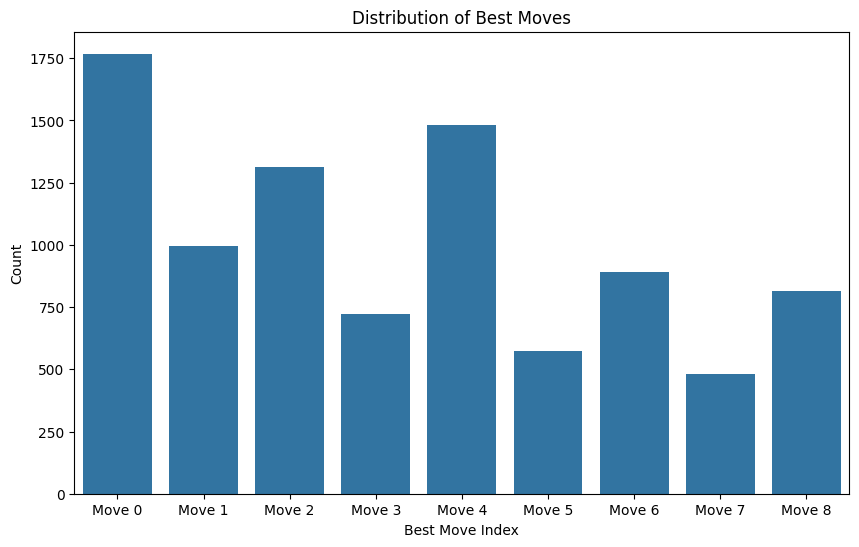

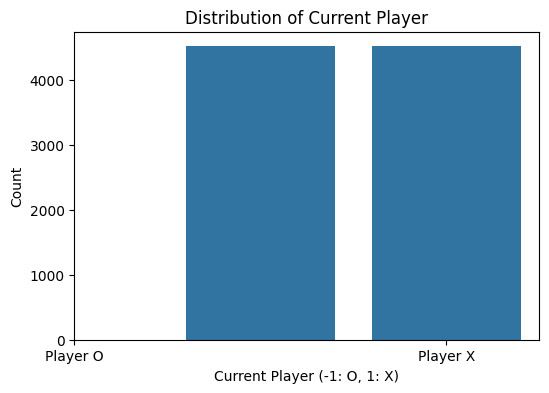

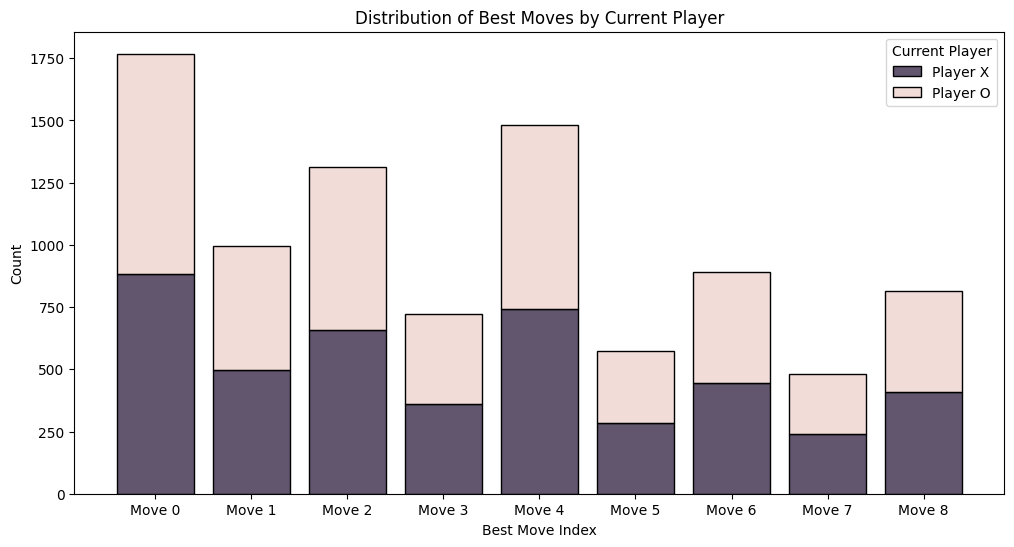

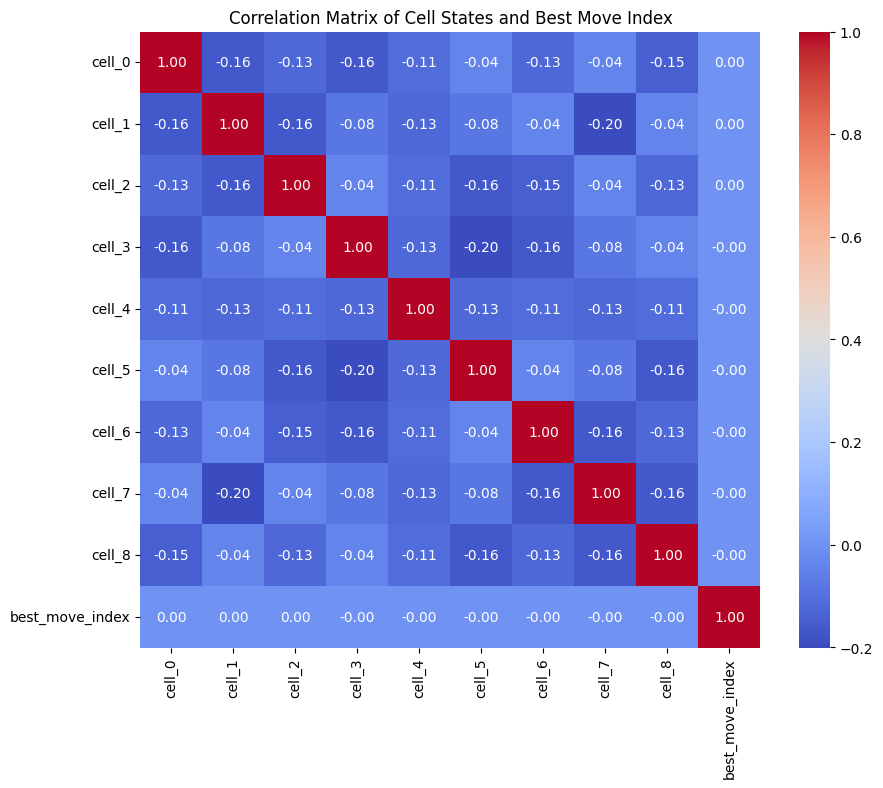

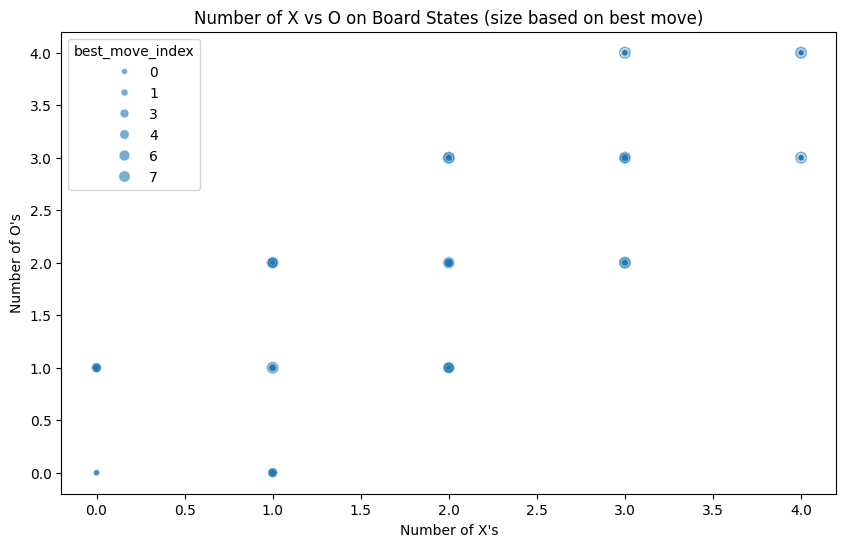

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of best moves
plt.figure(figsize=(10, 6))
sns.countplot(x='best_move_index', data=df)
plt.title('Distribution of Best Moves')
plt.xlabel('Best Move Index')
plt.ylabel('Count')
plt.xticks(np.arange(BOARD_SIZE * BOARD_SIZE), [f'Move {i}' for i in range(BOARD_SIZE * BOARD_SIZE)])
plt.show()

# Distribution of current players
plt.figure(figsize=(6, 4))
sns.countplot(x='current_player', data=df)
plt.title('Distribution of Current Player')
plt.xlabel('Current Player (-1: O, 1: X)')
plt.ylabel('Count')
plt.xticks([-1, 1], ['Player O', 'Player X'])
plt.show()

# Relationship between current player and best move (conditional distribution)
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='best_move_index', hue='current_player', multiple='stack', discrete=True, shrink=0.8)
plt.title('Distribution of Best Moves by Current Player')
plt.xlabel('Best Move Index')
plt.ylabel('Count')
plt.xticks(np.arange(BOARD_SIZE * BOARD_SIZE), [f'Move {i}' for i in range(BOARD_SIZE * BOARD_SIZE)])
plt.legend(title='Current Player', labels=['Player X', 'Player O'])
plt.show()

# Correlation matrix for cell values and best move index (less informative for categorical/discrete data like this, but can sometimes show patterns)
# Convert cell columns to numerical if they aren't already (they are in this case)
cell_columns = [f'cell_{i}' for i in range(BOARD_SIZE * BOARD_SIZE)]
correlation_cols = cell_columns + ['best_move_index']
correlation_matrix = df[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Cell States and Best Move Index')
plt.show()

# Example plot: Count of board states based on the number of 'X's and 'O's on the board
df['x_count'] = (df[cell_columns] == PLAYER_X).sum(axis=1)
df['o_count'] = (df[cell_columns] == PLAYER_O).sum(axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='x_count', y='o_count', size='best_move_index', alpha=0.6)
plt.title('Number of X vs O on Board States (size based on best move)')
plt.xlabel('Number of X\'s')
plt.ylabel('Number of O\'s')
plt.show()

# Remove the temporary columns
df = df.drop(columns=['x_count', 'o_count', 'empty_cell_count']) # Also drop 'empty_cell_count' which was added earlier


In [14]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
# Features are the board state and the current player
# Target is the index of the best move
X = df.drop(columns=['best_move_index'])
y = df['best_move_index']

# Split the dataset into training and testing sets
# test_size: the proportion of the dataset to include in the test split
# random_state: ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dataset split into training and testing sets:")
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Dataset split into training and testing sets:
Training features shape: (7232, 10)
Testing features shape: (1808, 10)
Training target shape: (7232,)
Testing target shape: (1808,)


In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create a Linear Regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model's performance

# Mean Squared Error (MSE): Measures the average of the squares of the errors
# Lower values indicate better performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE): The square root of the MSE, gives the error in the same units as the target variable
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R-squared (R2) Score: Represents the proportion of the variance in the dependent variable
# that is predictable from the independent variables.
# Ranges from 0 to 1 (or can be negative). Higher values indicate a better fit.
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R2) Score: {r2}")

# Note: Linear Regression might not be the best model for predicting discrete indices (0-8)
# More suitable models for this type of problem might be classification models
# (e.g., Logistic Regression, Decision Trees, Random Forests, SVM, Neural Networks)
# or regression models designed for integer targets (less common).
# However, this code demonstrates how to apply and evaluate a Linear Regression model.

# You might want to round or cast the predictions to integers if you want to interpret them as move indices
y_pred_rounded = np.round(y_pred).astype(int)

# You could also evaluate how many predictions match the actual best move index
# This is more of a classification-like evaluation
accuracy = np.mean(y_pred_rounded == y_test)
print(f"Simple Prediction Accuracy (Rounded): {accuracy}")

Mean Squared Error (MSE): 6.68150956473231
Root Mean Squared Error (RMSE): 2.584861614232435
R-squared (R2) Score: -0.002235939331060255
Simple Prediction Accuracy (Rounded): 0.08794247787610619


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,249 (40.04 KB)

 Trainable params: 10,249 (40.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2479 - loss: 2.0603 - val_accuracy: 0.5232 - val_loss: 1.6116
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5838 - loss: 1.4088 - val_accuracy: 0.6911 - val_loss: 1.0227
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7270 - loss: 0.8810 - val_accuracy: 0.7450 - val_loss: 0.7426
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7916 - loss: 0.6628 - val_accuracy: 0.7789 - val_loss: 0.6262
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8193 - loss: 0.5352 - val_accuracy: 0.7809 - val_loss: 0.5684
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8332 - loss: 0.4872 - val_accuracy: 0.8086 - val_loss: 0.5335
Epoch 7/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8502 - loss: 0.4444 - val_accuracy: 0.8093 - val_loss: 0.5017
Epoch 8/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8466 - loss: 0.4252 - val_accuracy: 0.

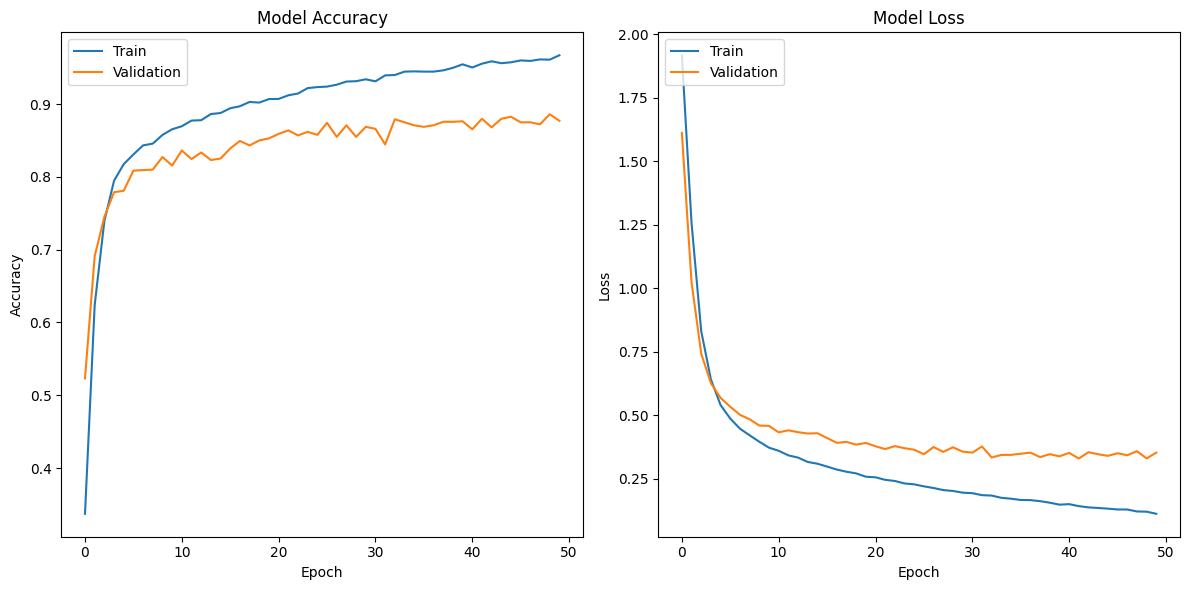

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert target variable to categorical for classification
# Since the target is an index from 0 to 8, we need to convert it to one-hot encoding
from tensorflow.keras.utils import to_categorical
num_classes = BOARD_SIZE * BOARD_SIZE # 9 possible moves
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Create the MLP model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu')) # Input layer and first hidden layer
model.add(Dense(64, activation='relu')) # Second hidden layer
model.add(Dense(num_classes, activation='softmax')) # Output layer with softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
# epochs: number of times to iterate over the training dataset
# batch_size: number of samples per gradient update
# validation_split: fraction of the training data to be used as validation data
history = model.fit(X_train_scaled, y_train_categorical, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test_categorical, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1) # Get the index of the highest probability

# Display classification metrics
print("\nClassification Report:")
# The target names should correspond to the move indices (0-8)
target_names = [str(i) for i in range(num_classes)]
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot training history (loss and accuracy)
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [28]:
import numpy as np
model.save('tic_tac_toe_mlp_model.h5')

print("MLP model saved to tic_tac_toe_mlp_model.h5")
print("\nTo use the saved model:")
print("1. Load the model using `tensorflow.keras.models.load_model('tic_tac_toe_mlp_model.h5')`")
print("2. You will also need the `scaler` object used during training to scale new input data.")
print("   You should save and load the scaler using libraries like `joblib` or `pickle`.")
print("3. Prepare your new board state and current player as a NumPy array.")
print("4. Scale the new input data using the loaded scaler.")
print("5. Use `model.predict(scaled_input_data)` to get probability predictions for each move.")
print("6. Use `np.argmax(predictions, axis=1)` to get the predicted best move index.")
print("7. Convert the move index back to a (row, col) tuple using `(move_index // BOARD_SIZE, move_index % BOARD_SIZE)`.")



MLP model saved to tic_tac_toe_mlp_model.h5

To use the saved model:
1. Load the model using `tensorflow.keras.models.load_model('tic_tac_toe_mlp_model.h5')`
2. You will also need the `scaler` object used during training to scale new input data.
   You should save and load the scaler using libraries like `joblib` or `pickle`.
3. Prepare your new board state and current player as a NumPy array.
4. Scale the new input data using the loaded scaler.
5. Use `model.predict(scaled_input_data)` to get probability predictions for each move.
6. Use `np.argmax(predictions, axis=1)` to get the predicted best move index.
7. Convert the move index back to a (row, col) tuple using `(move_index // BOARD_SIZE, move_index % BOARD_SIZE)`.


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create a Random Forest Classifier model
# n_estimators: the number of trees in the forest
# random_state: ensures reproducibility
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model's performance

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
# The target names should correspond to the move indices (0-8)
target_names = [str(i) for i in range(BOARD_SIZE * BOARD_SIZE)]
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
conf_matrix


Accuracy Score: 0.8103

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       330
           1       0.83      0.77      0.80       217
           2       0.83      0.83      0.83       271
           3       0.82      0.70      0.76       159
           4       0.80      0.86      0.83       275
           5       0.82      0.69      0.75       105
           6       0.84      0.81      0.82       181
           7       0.88      0.76      0.82       105
           8       0.78      0.82      0.80       165

    accuracy                           0.81      1808
   macro avg       0.82      0.79      0.80      1808
weighted avg       0.81      0.81      0.81      1808


Confusion Matrix:


array([[290,   3,  13,   0,  14,   1,   8,   1,   0],
       [ 11, 167,  10,   3,  11,   0,   5,   0,  10],
       [ 11,  12, 225,   3,  12,   1,   2,   0,   5],
       [ 15,   5,   4, 112,   6,   2,   7,   4,   4],
       [ 15,   3,   5,   4, 237,   3,   2,   1,   5],
       [  6,   3,   3,   3,   2,  72,   5,   4,   7],
       [ 12,   3,   4,   6,   5,   3, 147,   0,   1],
       [  4,   2,   5,   2,   3,   4,   0,  80,   5],
       [ 14,   2,   3,   3,   5,   2,   0,   1, 135]])